**Import libraries**

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

**Load file as dataframe**

In [6]:
folder_path = "emg_data_original"
file_names = [f"grip_{i}.txt" for i in range(1, 13)]  # grip_1.txt to grip_12.txt

# Initialize an empty list to store DataFrames
all_data = []

# Loop through each file and load its data
for grip_num, file_name in enumerate(file_names, start=1):
    file_path = os.path.join(folder_path, file_name)
    
    data = []
    gesture_repetition = 0

    # Read the file line by line
    with open(file_path, "r") as file:
        for line in file:
            line = line.strip()

            # If "#" appears, increase repetition count
            if line.startswith("#"):
                gesture_repetition += 1
                continue

            # Split by ";" and convert to float
            values = line.split(";")
            values = [float(v) for v in values if v]

            # Append to list with repetition index and grip pattern label
            data.append([gesture_repetition, grip_num] + values)

    # Convert to DataFrame
    columns = ["gesture_repetition", "grip_pattern", "ch1_env", "ch1_raw", "ch2_env", "ch2_raw", "ch3_env", "ch3_raw"]
    df = pd.DataFrame(data, columns=columns)
    df.dropna(inplace=True)  # Remove NaNs if any

    # Append to master list
    all_data.append(df)

# Merge all DataFrames into one
merged_df = pd.concat(all_data, ignore_index=True)

# Save merged dataset to CSV
merged_df.to_csv("emg_data_processed/merged_emg_data.csv", index=False)

print("Merged dataset saved as 'merged_emg_data.csv'.")
print(merged_df.head())  # Show first few rows

Merged dataset saved as 'merged_emg_data.csv'.
   gesture_repetition  grip_pattern   ch1_env  ch1_raw   ch2_env  ch2_raw  \
0                   1             1  0.103607  2.87193  0.154266  2.88742   
1                   1             1  0.103683  2.87384  0.154190  2.88933   
2                   1             1  0.103760  2.87804  0.154343  2.88811   
3                   1             1  0.103302  2.87369  0.153809  2.89009   
4                   1             1  0.103531  2.87132  0.154114  2.89024   

    ch3_env  ch3_raw  
0  0.089569  2.88391  
1  0.089722  2.88284  
2  0.089645  2.87964  
3  0.089645  2.87750  
4  0.091171  2.87956  


**Sliding windows**

In [ ]:
df = pd.read_csv("emg_data_processed/merged_emg_data.csv")

WINDOW_SIZE = 200  # 200 time steps per window
STEP_SIZE = 50  # Overlapping step size

windowed_data = []
windowed_labels = []

# Loop through each gesture repetition
for repetition in df["gesture_repetition"].unique():
    subset = df[df["gesture_repetition"] == repetition]  # Filter one repetition

    # Apply sliding window segmentation
    for start in range(0, len(subset) - WINDOW_SIZE, STEP_SIZE):
        window = subset.iloc[start : start + WINDOW_SIZE].drop(columns=["gesture_repetition", "grip_pattern"])
        windowed_data.append(window.values.flatten())  # Flatten to 1D
        windowed_labels.append(subset["grip_pattern"].iloc[start])  # Use first row's label

# Convert to DataFrame
num_features = WINDOW_SIZE * 6  # 6 EMG channels per time step
columns = [f"feature_{i}" for i in range(num_features)] + ["grip_pattern"]
windowed_df = pd.DataFrame(np.column_stack((windowed_data, windowed_labels)), columns=columns)

# Save processed dataset
windowed_df.to_csv("emg_data_processed/sliding_windows_emg.csv", index=False)

print(windowed_df.head())  # Check the first few rows

Sliding windows dataset saved as 'sliding_windows_emg.csv'.
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.103607    2.87193   0.154266    2.88742   0.089569    2.88391   
1   0.103226    2.87399   0.170288    2.89063   0.092850    2.87590   
2   0.103226    2.87262   0.179596    2.88712   0.098114    2.88811   
3   0.103607    2.87064   0.186920    2.89444   0.091705    2.89230   
4   0.103073    2.87788   0.178757    2.89055   0.100250    2.88437   

   feature_6  feature_7  feature_8  feature_9  ...  feature_1191  \
0   0.103683    2.87384   0.154190    2.88933  ...       2.89162   
1   0.103226    2.87491   0.170059    2.89383  ...       2.88643   
2   0.103226    2.87262   0.180054    2.88872  ...       2.88979   
3   0.103607    2.87415   0.186615    2.88948  ...       2.89459   
4   0.103302    2.87247   0.177612    2.89413  ...       2.88956   

   feature_1192  feature_1193  feature_1194  feature_1195  feature_1196  \
0      0.101242       2.88658

**Load and preprocess data for CNN**

In [9]:
df = pd.read_csv("emg_data_processed/sliding_windows_emg.csv")

# Separate features and labels
X = df.drop(columns=["grip_pattern"]).values
y = df["grip_pattern"].values

# Normalize for CNN performance
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for CNN: (samples, time_steps, channels)
time_steps = 200  # Each window has 200 time steps
num_channels = 6  # 6 EMG signals per time step
X = X.reshape((X.shape[0], time_steps, num_channels))

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (77628, 200, 6)
Testing Data Shape: (19407, 200, 6)


**One hot encoding for gesture labels**

In [10]:
y_train = np.array(y_train) - 1
y_test = np.array(y_test) - 1

# 12 grip patterns
num_classes = len(np.unique(y_train))

# Integer to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(y_train[:5])  # Print first 5 labels in one-hot format

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


**Build CNN**

In [ ]:
# Build function for tuning

def build_model(hp):
    model = Sequential([
        Input(shape=(time_steps, num_channels)),
        Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=16), 
               kernel_size=hp.Int('kernel_size', min_value=3, max_value=7, step=1), 
               activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=hp.Int('filters', min_value=16, max_value=64, step=8), 
               kernel_size=hp.Int('kernel_size', min_value=1, max_value=5, step=1), 
               activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(hp.Int('units', min_value=64, max_value=256, step=32), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.4, max_value=0.8, step=0.1)),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), 
                loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model

**Initialize and run tuner***

In [ ]:
tuner = kt.BayesianOptimization(build_model,objective='val_loss',max_trials=10)

tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Trial 10 Complete [00h 06m 27s]
val_loss: 0.07840508222579956

Best val_loss So Far: 0.06381803005933762
Total elapsed time: 00h 34m 07s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 197, 48)        │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 98, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 95, 48)         │         9,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 47, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2256)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       577,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,340 (2.26 MB)

 Trainable params: 591,340 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\Zaid\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 197, 48)        │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 98, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 95, 48)         │         9,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 47, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2256)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       577,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,340 (2.26 MB)

 Trainable params: 591,340 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

**Get best set of hyperparameters**

In [ ]:
best_hps_list = tuner.get_best_hyperparameters(num_trials=5)

for i, hps in enumerate(best_hps_list):
    print(f"Best Hyperparameters Set {i+1}: {hps.values}")

Best Hyperparameters Set 1: {'filters': 48, 'kernel_size': 4, 'units': 256, 'dropout': 0.6000000000000001}
Best Hyperparameters Set 2: {'filters': 96, 'kernel_size': 4, 'units': 64, 'dropout': 0.5}
Best Hyperparameters Set 3: {'filters': 128, 'kernel_size': 6, 'units': 64, 'dropout': 0.4}
Best Hyperparameters Set 4: {'filters': 112, 'kernel_size': 5, 'units': 96, 'dropout': 0.5}
Best Hyperparameters Set 5: {'filters': 64, 'kernel_size': 7, 'units': 96, 'dropout': 0.4}


**Train with best set of hyperparameters**

In [39]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 197, 48)        │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 98, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 95, 48)         │         9,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 47, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2256)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       577,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,340 (2.26 MB)

 Trainable params: 591,340 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7669 - loss: 0.6254 - val_accuracy: 0.9355 - val_loss: 0.1564
Epoch 2/20
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9227 - loss: 0.2184 - val_accuracy: 0.9589 - val_loss: 0.1222
Epoch 3/20
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9425 - loss: 0.1644 - val_accuracy: 0.9703 - val_loss: 0.0829
Epoch 4/20
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9486 - loss: 0.1500 - val_accuracy: 0.9266 - val_loss: 0.2001
Epoch 5/20
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9534 - loss: 0.1390 - val_accuracy: 0.9714 - val_loss: 0.0770
Epoch 6/20
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9566 - loss: 0.1256 - val_accuracy: 0.9609 - val_loss: 0.1069
Epoch 7/20
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9619 - loss: 0.1142 - val_accuracy: 0.9748 - val_loss: 0.0718
Epoch 8/20
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9650 - loss: 0

**Accuracy/loss plots**

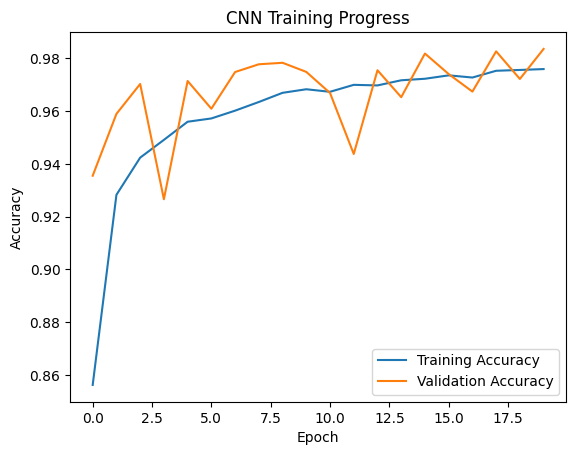

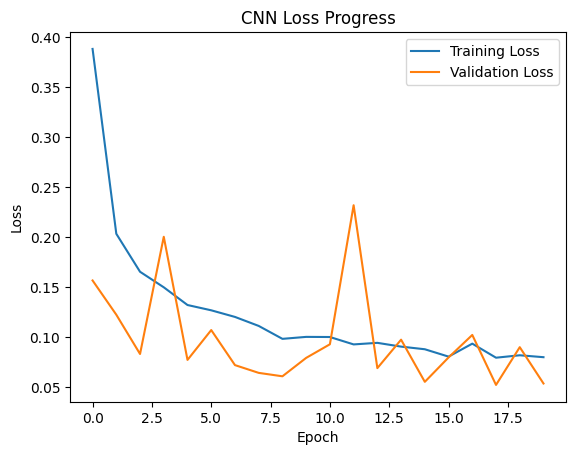

In [40]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN Training Progress")
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CNN Loss Progress")
plt.show()

**Save model**

In [41]:
model.save("models/cnn_tuned.keras")
print("Model saved successfully!")

Model saved successfully!
